In [5]:
import sys
print(sys.executable)

/Users/isaaclee/Desktop/VS.CODE/PROGRAMS/ObjectDetection/TFODCourse/tfod/bin/python3


Loaded 5000 data points

Euler angle ranges:
Roll:  -10.13° to 8.78°
Pitch: -10.98° to 7.91°
Yaw:   -179.99° to 180.00°


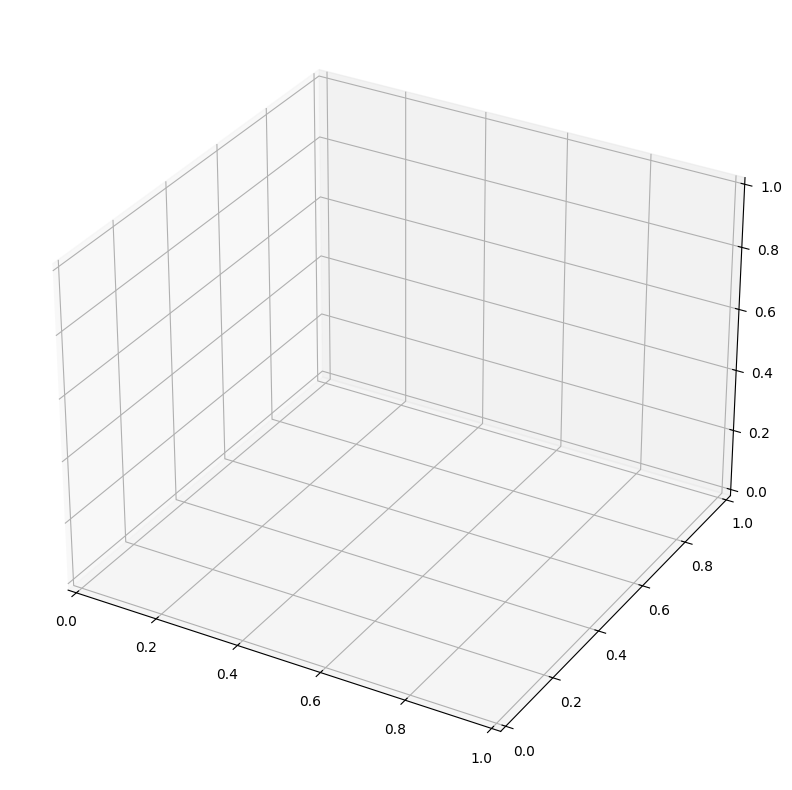

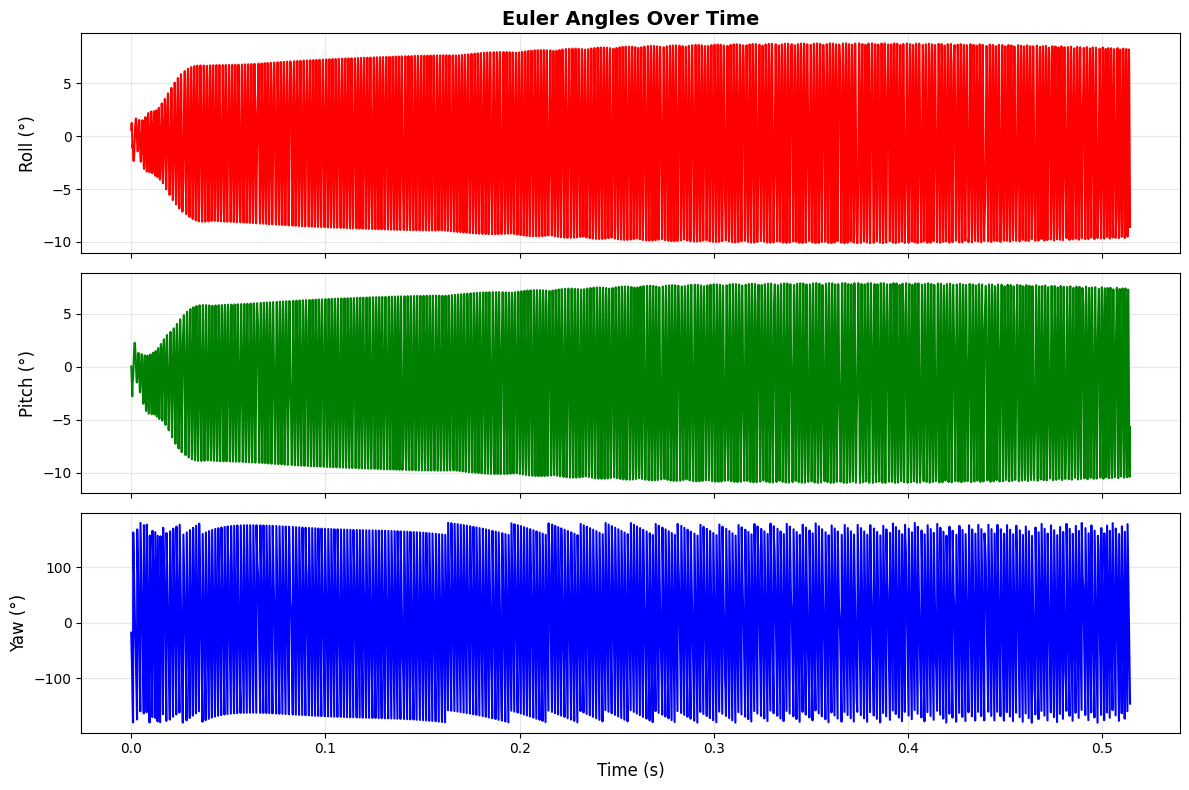

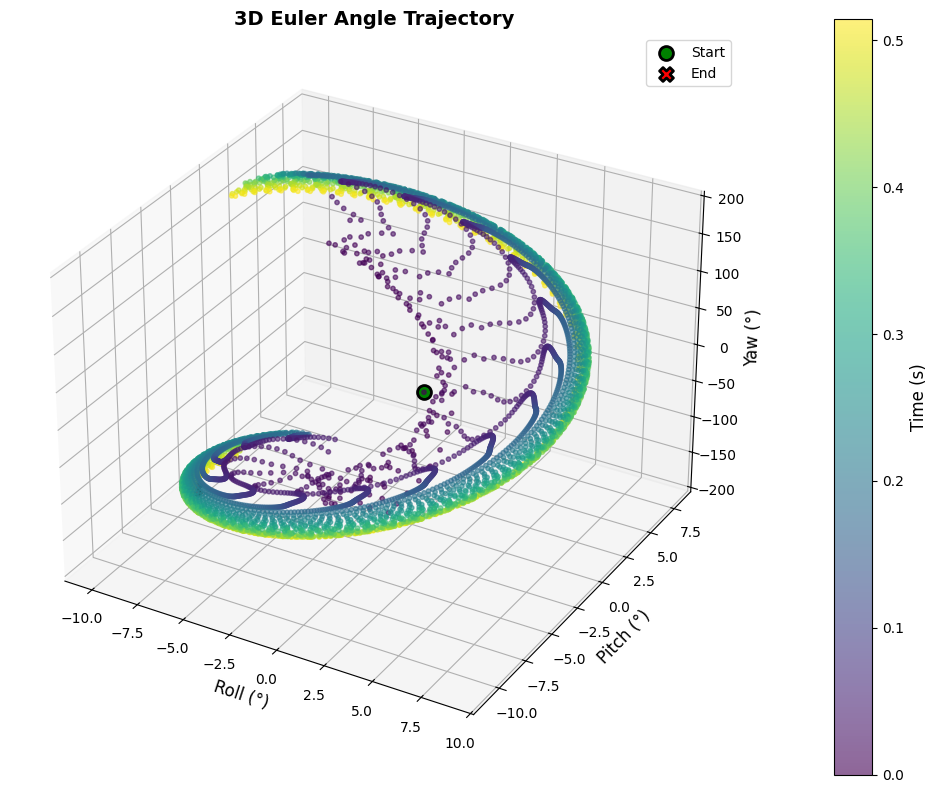


ORIENTATION STATISTICS

Total duration: 0.514 seconds
Number of samples: 5000
Average sample rate: 9723.8 Hz

Euler Angle Statistics:
  Roll:  mean= -0.57°, std=  6.12°, range=[-10.13°,   8.78°]
  Pitch: mean= -1.47°, std=  6.10°, range=[-10.98°,   7.91°]
  Yaw:   mean=  0.92°, std=103.62°, range=[-179.99°, 180.00°]

Processed data saved to 'quaternion_euler_results.csv'


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from pyquaternion import Quaternion
from IPython.display import HTML

# Load the quaternion data
df = pd.read_csv('quaternion_results.csv')

# Convert quaternions to Euler angles (roll, pitch, yaw)
def quaternion_to_euler(qw, qx, qy, qz):
    """
    Convert quaternion to Euler angles (roll, pitch, yaw) in degrees
    """
    q = Quaternion(qw, qx, qy, qz)
    
    # Get Euler angles in radians
    yaw, pitch, roll = q.yaw_pitch_roll
    
    # Convert to degrees
    return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)

# Apply conversion to all rows
euler_angles = df.apply(
    lambda row: quaternion_to_euler(row['qw'], row['qx'], row['qy'], row['qz']), 
    axis=1
)

df['roll'] = [e[0] for e in euler_angles]
df['pitch'] = [e[1] for e in euler_angles]
df['yaw'] = [e[2] for e in euler_angles]

# Normalize time to start at 0
df['time_normalized'] = df['time'] - df['time'].iloc[0]

print(f"Loaded {len(df)} data points")
print(f"\nEuler angle ranges:")
print(f"Roll:  {df['roll'].min():.2f}° to {df['roll'].max():.2f}°")
print(f"Pitch: {df['pitch'].min():.2f}° to {df['pitch'].max():.2f}°")
print(f"Yaw:   {df['yaw'].min():.2f}° to {df['yaw'].max():.2f}°")

# ============= ANIMATION 1: 3D Orientation Visualization =============

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define body frame axes (initial orientation)
axis_length = 1.5
colors = ['r', 'g', 'b']
axis_labels = ['X (Roll)', 'Y (Pitch)', 'Z (Yaw)']

def init():
    ax.clear()
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Orientation (Body Frame)')
    return []

def update(frame):
    ax.clear()
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Get quaternion at this frame
    qw, qx, qy, qz = df.iloc[frame][['qw', 'qx', 'qy', 'qz']]
    q = Quaternion(qw, qx, qy, qz)
    
    # Get rotation matrix
    R = q.rotation_matrix
    
    # Draw body frame axes
    origin = np.array([0, 0, 0])
    for i, (color, label) in enumerate(zip(colors, axis_labels)):
        # Body axis direction
        axis_direction = R[:, i] * axis_length
        ax.quiver(origin[0], origin[1], origin[2],
                 axis_direction[0], axis_direction[1], axis_direction[2],
                 color=color, arrow_length_ratio=0.2, linewidth=3,
                 label=label)
    
    # Draw world frame (gray, thinner)
    for i in range(3):
        world_axis = np.zeros(3)
        world_axis[i] = axis_length
        ax.quiver(0, 0, 0, world_axis[0], world_axis[1], world_axis[2],
                 color='gray', alpha=0.3, arrow_length_ratio=0.15, linewidth=1)
    
    # Display Euler angles
    roll, pitch, yaw = df.iloc[frame][['roll', 'pitch', 'yaw']]
    time_val = df.iloc[frame]['time_normalized']
    
    ax.set_title(f'3D Orientation (Frame {frame}/{len(df)})\n' +
                f'Time: {time_val:.3f}s | ' +
                f'Roll: {roll:.1f}° | Pitch: {pitch:.1f}° | Yaw: {yaw:.1f}°',
                fontsize=12)
    
    ax.legend(loc='upper right')
    
    return []

# Create animation (downsample if too many frames)
skip = max(1, len(df) // 500)  # Limit to ~500 frames
anim = FuncAnimation(fig, update, init_func=init, 
                    frames=range(0, len(df), skip),
                    interval=50, blit=False)

plt.tight_layout()
plt.show()

# To save the animation (uncomment if needed):
# anim.save('orientation_animation.mp4', writer='ffmpeg', fps=20)
# anim.save('orientation_animation.gif', writer='pillow', fps=20)


# ============= PLOT 2: Euler Angles Over Time =============

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df['time_normalized'], df['roll'], 'r-', linewidth=1.5)
axes[0].set_ylabel('Roll (°)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Euler Angles Over Time', fontsize=14, fontweight='bold')

axes[1].plot(df['time_normalized'], df['pitch'], 'g-', linewidth=1.5)
axes[1].set_ylabel('Pitch (°)', fontsize=12)
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['time_normalized'], df['yaw'], 'b-', linewidth=1.5)
axes[2].set_ylabel('Yaw (°)', fontsize=12)
axes[2].set_xlabel('Time (s)', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# ============= PLOT 3: 3D Trajectory of Euler Angles =============

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
scatter = ax.scatter(df['roll'], df['pitch'], df['yaw'], 
                    c=df['time_normalized'], cmap='viridis', 
                    s=10, alpha=0.6)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Time (s)', fontsize=12)

# Mark start and end
ax.scatter(df['roll'].iloc[0], df['pitch'].iloc[0], df['yaw'].iloc[0], 
          color='green', s=100, marker='o', label='Start', edgecolors='black', linewidth=2)
ax.scatter(df['roll'].iloc[-1], df['pitch'].iloc[-1], df['yaw'].iloc[-1], 
          color='red', s=100, marker='X', label='End', edgecolors='black', linewidth=2)

ax.set_xlabel('Roll (°)', fontsize=12)
ax.set_ylabel('Pitch (°)', fontsize=12)
ax.set_zlabel('Yaw (°)', fontsize=12)
ax.set_title('3D Euler Angle Trajectory', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


# ============= STATISTICS =============

print("\n" + "="*50)
print("ORIENTATION STATISTICS")
print("="*50)
print(f"\nTotal duration: {df['time_normalized'].iloc[-1]:.3f} seconds")
print(f"Number of samples: {len(df)}")
print(f"Average sample rate: {len(df)/df['time_normalized'].iloc[-1]:.1f} Hz")

print("\nEuler Angle Statistics:")
print(f"  Roll:  mean={df['roll'].mean():6.2f}°, std={df['roll'].std():6.2f}°, range=[{df['roll'].min():6.2f}°, {df['roll'].max():6.2f}°]")
print(f"  Pitch: mean={df['pitch'].mean():6.2f}°, std={df['pitch'].std():6.2f}°, range=[{df['pitch'].min():6.2f}°, {df['pitch'].max():6.2f}°]")
print(f"  Yaw:   mean={df['yaw'].mean():6.2f}°, std={df['yaw'].std():6.2f}°, range=[{df['yaw'].min():6.2f}°, {df['yaw'].max():6.2f}°]")

# Save processed data
df.to_csv('quaternion_euler_results.csv', index=False)
print(f"\nProcessed data saved to 'quaternion_euler_results.csv'")

